In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
import classifier_utils as utils

In [4]:
import cnn_classifier

In [5]:
import context_classifier

# Get Dataset

In [6]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

train, test = utils.get_augmented_dataset_divided_per_image(categories)

# Carve out a validation set from our test set
# Split it 50/50
# Need to shuffle the test set before splitting
np.random.seed(8080) # repeatability
N = len(test['patches'])
new_N = N/2
perm = np.random.permutation(N)
validation = {}
for k in list(test.iterkeys()):
    values = test[k]
    test[k], validation[k] = np.split(values[perm], [new_N])

Dropped 1559 patches because too close to image border
Dropped 523 patches because too close to image border


In [7]:
for (k, v) in train.iteritems():
    print "train", k, v.shape
for (k, v) in test.iteritems():
    print "test", k, v.shape
for (k, v) in validation.iteritems():
    print "validation", k, v.shape

train hsv_factors (60000, 3)
train deltas (60000, 2)
train patches (60000, 27, 27, 3)
train rots (60000,)
train labels (60000, 4)
train flips (60000,)
train centres (60000, 2)
train img_ids (60000,)
test img_ids (2296,)
test labels (2296, 4)
test patches (2296, 27, 27, 3)
test centres (2296, 2)
validation img_ids (2297,)
validation labels (2297, 4)
validation patches (2297, 27, 27, 3)
validation centres (2297, 2)


In [8]:
# Sanity-check that the test and train data come from different images
test_img_ids = set(test['img_ids'])
train_img_ids = set(train['img_ids'])
print "Train:", sorted(train_img_ids)
print "Test:", sorted(test_img_ids)
print "Intersection:", sorted(train_img_ids.intersection(test_img_ids))

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 40, 41, 42, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 66, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]
Test: [9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64, 65, 67, 70, 81, 83, 87, 88, 96]
Intersection: []


In [9]:
# DELETE ME
# Temp for spot check
(all_imgs, _, _) = utils.get_dataset(100, categories)

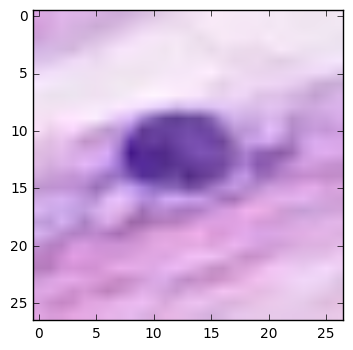

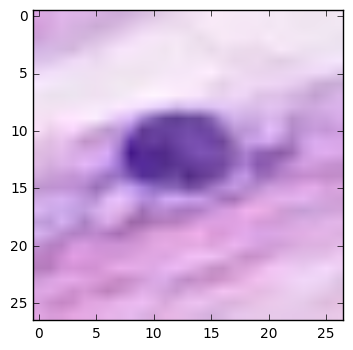

In [10]:
# DELETE ME
# Spot check
i = 420
plt.figure()
plt.imshow(test['patches'][i])
(x, y) = test['centres'][i]
img_id = test['img_ids'][i]
img = all_imgs[img_id]
plt.figure()
plt.imshow(img[y-13:y+14,x-13:x+14])

# Train a Softmax CNN Model

In [11]:
try:
    sess.close()
except:
    pass # sess doesn't exist yet!

tf.reset_default_graph()
sess = tf.InteractiveSession()

patch_model = cnn_classifier.SoftmaxCNNModel()

In [111]:
num_epochs = 20
batch_size = 100
tr_loss, tst_loss = patch_model.train_loop(sess,
                                           train['patches']*255,
                                           train['labels'],
                                           test['patches']*255,
                                           test['labels'],
                                           num_epochs,
                                           batch_size)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, step 0, training loss 1.386460, test_loss 1.387063, accuracy = 0.207272/0.250163, f1 = nan
Epoch 0, step 25, training loss 1.386188, test_loss 1.387260, accuracy = 0.230786/0.259525, f1 = nan
Epoch 0, step 50, training loss 1.384773, test_loss 1.387609, accuracy = 0.238189/0.249946, f1 = nan
Epoch 0, step 75, training loss 1.386149, test_loss 1.388587, accuracy = 0.238842/0.251034, f1 = nan
Epoch 0, step 100, training loss 1.385368, test_loss 1.388743, accuracy = 0.241890/0.266057, f1 = nan
Epoch 0, step 125, training loss 1.384659, test_loss 1.388955, accuracy = 0.204224/0.246897, f1 = nan
Epoch 0, step 150, training loss 1.385288, test_loss 1.390291, accuracy = 0.209885/0.249075, f1 = nan
Epoch 0, step 175, training loss 1.384866, test_loss 1.389790, accuracy = 0.223166/0.249728, f1 = nan
Epoch 0, step 200, training loss 1.382402, test_loss 1.388770, accuracy = 0.224907/0.250163, f1 = nan
Epoch 0, step

In [112]:
# Save the model
saver = tf.train.Saver(write_version=1)
save_path = saver.save(sess, "context_models/patch_models/v2/model.ckpt")
print "Saved to:", save_path

Saved to: context_models/patch_models/v2/model.ckpt


In [12]:
# Restore the model
saver = tf.train.Saver()
saver.restore(sess, "context_models/patch_models/v2/model.ckpt")

In [14]:
# Check that we get the expected f1
sess.run(patch_model.f1, feed_dict={
        patch_model.patch_tensor:np.concatenate([test['patches'], validation['patches']], axis=0)*255,
        patch_model.label_tensor:np.concatenate([test['labels'], validation['labels']], axis=0),
    })

0.76079822

# Get Non-Augmented Dataset

In [15]:
(train_vanilla, _) = utils.get_dataset_divided_per_image(categories)

Dropped 1559 patches because too close to image border
Dropped 523 patches because too close to image border


# Derp Around

In [ ]:
(train_vanilla, test_vanilla) = utils.get_dataset_divided_per_image(categories)

In [115]:
import classifier_utils as utils
reload(utils)

<module 'classifier_utils' from 'classifier_utils.py'>

In [119]:
for (k, v) in train_vanilla.iteritems():
    print "train", k, v.shape

train img_ids (15769,)
train labels (15769, 4)
train patches (15769, 27, 27, 3)
train centres (15769, 2)


1917
[1 0 0 0]
[1 0 0 0]


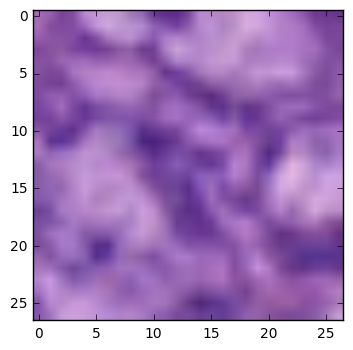

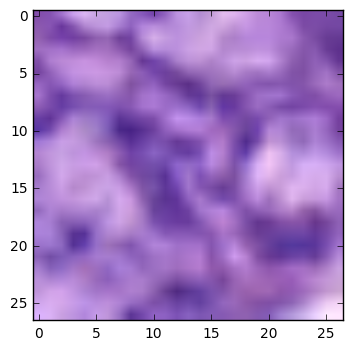

In [137]:
target = 1010
i = train['img_ids'][target]
c = train['centres'][target]
for ii in xrange(len(train_vanilla['img_ids'])):
    if train_vanilla['img_ids'][ii] == i and np.all(np.equal(train_vanilla['centres'][ii], c)):
        break
print ii
plt.imshow(train['patches'][target])
plt.figure()
plt.imshow(train_vanilla['patches'][ii])
print train['labels'][target]
print train_vanilla['labels'][ii]

# Compute Probability Weight Neighbourhoods

In [16]:
bin_size = 27
context = 5
test['probabilities'], test['weight_neighbourhoods'] = \
    context_classifier.compute_probability_neighbourhoods(sess, test, patch_model, bin_size=bin_size, context_length=context)
validation['probabilities'], validation['weight_neighbourhoods'] = \
    context_classifier.compute_probability_neighbourhoods(sess, validation, patch_model, bin_size=bin_size, context_length=context)
train_vanilla['probabilities'], train_vanilla['weight_neighbourhoods'] = \
    context_classifier.compute_probability_neighbourhoods(sess, train_vanilla, patch_model, bin_size=bin_size, context_length=context)

# Balance Classes

In [17]:
# Let's just try to balance out the classes a little
selectors = []
for c in xrange(train_vanilla['labels'].shape[1]):
    selectors.append(np.nonzero(train_vanilla['labels'][:,c])[0])
largest_class_size = max([len(s) for s in selectors])
#print largest_class_size
expanded_selectors = []
for s in selectors:
    expansion_factor = largest_class_size / len(s) + 1
    expanded_selectors.append(np.repeat(s, expansion_factor)[:largest_class_size])
    
np.random.seed(649) # repeatability
balanced_train_vanilla = {}
N = len(selectors) * largest_class_size
perm = np.random.permutation(N)
for (k, v) in train_vanilla.iteritems():
    new = np.concatenate([v[s] for s in expanded_selectors], axis=0)
    #print new.shape
    balanced_train_vanilla[k] = new[perm]
    #print balanced_train_vanilla[k].shape

In [18]:
for (k, v) in balanced_train_vanilla.iteritems():
    print k, v.shape

patches (20696, 27, 27, 3)
probabilities (20696, 4)
labels (20696, 4)
weight_neighbourhoods (20696, 5, 5, 4)
centres (20696, 2)
img_ids (20696,)


In [19]:
print np.count_nonzero(balanced_train_vanilla['labels'][:,0])
print np.count_nonzero(balanced_train_vanilla['labels'][:,1])
print np.count_nonzero(balanced_train_vanilla['labels'][:,2])
print np.count_nonzero(balanced_train_vanilla['labels'][:,3])

5174
5174
5174
5174


# Train the Context Model

In [20]:
reload(context_classifier)

<module 'context_classifier' from 'context_classifier.pyc'>

In [21]:
try:
    sess.close()
except:
    pass # sess doesn't exist yet!

tf.reset_default_graph()
sess = tf.InteractiveSession()

learning_rate = tf.Variable(0.001, trainable=False)
context_model = context_classifier.ContextModel(learning_rate=learning_rate, context_length=context)

In [388]:
num_epochs = 200
batch_size = 50
tr_loss, tst_loss = context_model.train_loop(
    sess,
    balanced_train_vanilla['probabilities'],
    balanced_train_vanilla['weight_neighbourhoods'],
    balanced_train_vanilla['labels'],
    validation['probabilities'],
    validation['weight_neighbourhoods'],
    validation['labels'],
    num_epochs,
    batch_size)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, step 0, training loss 1.717754, test_loss 1.717083, accuracy = 0.246844/0.383544, f1 = nan
Epoch 0, step 25, training loss 1.330503, test_loss 1.288229, accuracy = 0.400522/0.269047, f1 = nan
Epoch 0, step 50, training loss 1.137076, test_loss 1.138435, accuracy = 0.515020/0.275142, f1 = nan
Epoch 0, step 75, training loss 1.052572, test_loss 1.061964, accuracy = 0.566391/0.278189, f1 = nan
Epoch 0, step 100, training loss 1.028090, test_loss 0.992262, accuracy = 0.628211/0.261210, f1 = nan
Epoch 0, step 125, training loss 0.938842, test_loss 0.972623, accuracy = 0.639965/0.261210, f1 = nan
Epoch 0, step 150, training loss 1.038469, test_loss 0.962677, accuracy = 0.645625/0.261210, f1 = nan
Epoch 0, step 175, training loss 0.849236, test_loss 0.953923, accuracy = 0.656073/0.261210, f1 = nan
Epoch 0, step 200, training loss 0.834316, test_loss 0.914633, accuracy = 0.680453/0.261210, f1 = nan
Epoch 0, step

In [24]:
# Load the best model
saver = tf.train.Saver()
saver.restore(sess, "context_models/neighbourhood_models/tmp/model.ckpt")

# Evaluate f1
print sess.run(context_model.f1, feed_dict={
        context_model.probability_tensor:test['probabilities'],
        context_model.neighbourhood_tensor:test['weight_neighbourhoods'],
        context_model.label_tensor:test['labels'],
    })

# Show confusion matrix
print sess.run(context_model.confusion, feed_dict={
        context_model.probability_tensor:test['probabilities'],
        context_model.neighbourhood_tensor:test['weight_neighbourhoods'],
        context_model.label_tensor:test['labels'],
    })

0.812979
[[842  68  26  38]
 [ 44 421  52  30]
 [  4  55 465  45]
 [ 12  39  25 130]]


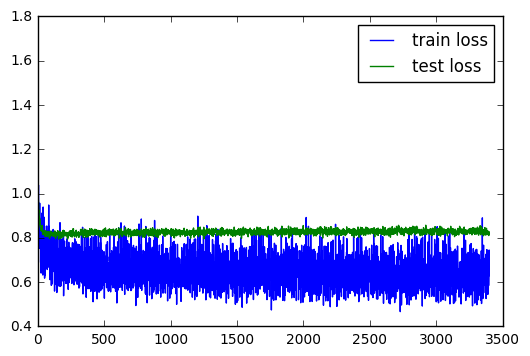

In [393]:
tr_loss2 = []
tst_loss2 = []
tr_loss_overall = tr_loss + tr_loss2
tst_loss_overall = tst_loss + tst_loss2
x = range(len(tr_loss_overall))
plt.plot(x, tr_loss_overall, label='train loss')
plt.plot(x, tst_loss_overall, label='test loss')
plt.legend()

In [377]:
# Save the model
saver = tf.train.Saver(write_version=1)
save_path = saver.save(sess, "context_models/neighbourhood_models/v4/model.ckpt",)
print "Saved to:", save_path

Saved to: context_models/neighbourhood_models/v3/model.ckpt
